In [1]:
import sys
sys.path.append("/home/dictus/dmt/v2")
from neuro_dmt.library.users.hugo.validations import SimpleValidation

In [45]:
from dmt.model.interface import Interface
from neuro_dmt.library.users.hugo.adapters import PRESYNAPTIC, POSTSYNAPTIC
import pandas as pd
from seaborn import heatmap


def plot_pre_post_heatmap(label, df):
    
    # TODO: test and handle case when not all groups have same parameters
    def make_hashable(df, columnlabel):
        # currently assume all entries have the same keys
        dict_column = df[columnlabel]
        keys = dict_column[0].keys()
        cat_column_label = columnlabel + ": " + ", ".join(keys)
        column_values = [", ".join(str(v) for v in d.values()) for d in dict_column.values]
        return df.drop(columns=columnlabel).assign(**{cat_column_label: column_values}), cat_column_label

    df, pre_col = make_hashable(df, PRESYNAPTIC)
    df, post_col = make_hashable(df, POSTSYNAPTIC)
    df_matrix = df.pivot_table(index=pre_col, columns=post_col, values='mean')
    fig = heatmap(df_matrix)
    return fig


def cplot(labels, results_dataframes):
    from dmt.tk.plotting.circle import CirclePlot
    ax = CirclePlot(space_between=0.1).plot(results_dataframes[0])
    ax.set_title(labels[0])
    return ax

def by_mtype(model):
        """
        gets the available mtypes from the model
        effectively makes this a 'by mtype' validation
        """
        mtypes = model.mtypes()
        return [{PRESYNAPTIC: pre, POSTSYNAPTIC: post} for pre in mtypes for post in mtypes]



class SynapsesPerConnectionAnalysis(SimpleValidation):
    
    class AdapterInterface(Interface):
        
        def synapses_per_connection(model, parameters):
            """
            get the number of synapses per connection from the model
            for the pathway defined be pre and post mtype
            
            Arguments:
                model: the model to get the data from
                pre_mtype: string, the presynaptic mtype
                post_mtype: string, the postsynaptic mtype
            
            Returns:
                Array: number of synapses for each connection sampled
            """
            raise NotImplementedError
    

    
    def get_measurement(self, model, parameters):
        """
        get the measurement from the model
        Arguments:
            parameters: dict with keys PRESYNAPTIC and POSTSYNAPTIC
                        and values which are each a set of parameters
                        for pre and postsynaptic cells
        """
        return model.synapses_per_connection(parameters) 
        
    def plot(self, labels, results_dataframes):
        return cplot(labels, results_dataframes)


class ByMtypeSynapsesPerConnectionAnalysis(SynapsesPerConnectionAnalysis):
    
    class AdapterInterface(SynapsesPerConnectionAnalysis.AdapterInterface):
        
        def mtypes(model):
            """
            get all of the mytpes in the model
            Arguments:
               model: the model to get mtypes from
            
            Returns:
               iterable of mtypes (string)
            """
            raise NotImplementedError
            
    def measurements_parameters(self, model):
        """{}""".format(by_mtype.__doc__)
        return by_mtype(model)

In [46]:
import numpy as np

class DummyAdapter:
    
    label = 'dummy model'
    
    def synapses_per_connection(self, params):
        return np.random.poisson(np.random.poisson(10), 1 + np.random.poisson(1))
    
    def mtypes(self):
        return [{'mtype': letter} for letter in ['a', 'b', 'c', 'd', 'e', 'f']]
    

In [47]:
print(DummyAdapter().synapses_per_connection(''),
DummyAdapter().synapses_per_connection(''),
DummyAdapter().synapses_per_connection(''),
DummyAdapter().synapses_per_connection(''))

[8] [11 12] [10] [8]


post: mtype     a      b          c          d    e          f
pre: mtype                                                    
a             7.5   5.00   6.000000  12.000000  7.0   7.000000
b            14.5   5.25   8.666667  16.000000  7.0   9.666667
c             6.0   4.00   6.000000   8.000000  6.0  12.333333
d             9.5   9.00  12.600000  18.333333  4.5   6.500000
e             6.0   9.00   7.000000  11.000000  7.0  10.500000
f            11.0  14.50   8.000000   8.666667  9.5   8.000000


/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:42: Warning: <__main__.ByMtypeSynapsesPerConnectionAnalysis object at 0x7efd201362e8> does not have a phenomenon, defaulting to 'Not Provided'
  .format(self)))


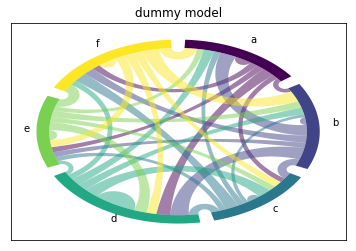

In [49]:
report = ByMtypeSynapsesPerConnectionAnalysis()(DummyAdapter())

In [6]:

class ConnectionProbabilityAnalysis(SimpleValidation):
    
    class AdapterInterface(Interface):
        
        def connection_probability(model, parameters):
            """
            get the probability of a connection between cells
            
            Arguments:
                model: the adapted model to extract data from
                parameters: dict with 'pre' and 'post' parameter sets
            
            Returns:
                Array: number of synapses for each connection sampled
            """
            raise NotImplementedError
    
    def get_measurement(self, model, parameters):
        """
        get the measurement from the model
        """
        return model.connection_probability(parameters, sample_size=10, nsamples=100)
       
        
    def plot(self, labels, results_dataframes):
        return plot_pre_post_heatmap(labels[0], results_dataframes[0])
 
# TODO: there is some code duplication here. will be fixed once measurements_parameters is a component
class ByMtypeConnectionProbabilityAnalysis(ConnectionProbabilityAnalysis):
    
    class AdapterInterface(ConnectionProbabilityAnalysis.AdapterInterface):
        
        def mtypes(model):
            """
            get all of the mytpes in the model
            Arguments:
               model: the model to get mtypes from
            
            Returns:
               iterable of mtypes (string)
            """
            raise NotImplementedError
        
    def measurements_parameters(self, model):
        """{}""".format(by_mtype.__doc__)
        return by_mtype(model)

In [7]:

class PathwaySynapsesAnalysis(SimpleValidation):
    
    class AdapterInterface(Interface):
        
        def pathway_synapses(model, parameters):
            """
            get the total number of synapses on one group of cells from another
            
            Arguments:
                model: the adapted model to extract data from
                parameters: dict with 'pre' and 'post' parameter sets
            
            Returns:
                Array: number of synapses for each connection sampled
            """
            raise NotImplementedError
    
    def get_measurement(self, model, parameters):
        """
        get the measurement from the model
        """
        return model.pathway_synapses(parameters, sample_size=10, nsamples=100)
       
        
    def plot(self, labels, results_dataframes):
        return plot_pre_post_heatmap(labels[0], results_dataframes[0])
 
# TODO: there is some code duplication here. will be fixed once measurements_parameters is a component
class ByMtypePathwaySynapsesAnalysis(PathwaySynapsesAnalysis):
    
    class AdapterInterface(PathwaySynapsesAnalysis.AdapterInterface):
        
        def mtypes(model):
            """
            get all of the mytpes in the model
            Arguments:
               model: the model to get mtypes from
            
            Returns:
               iterable of mtypes (string)
            """
            raise NotImplementedError
        
    def measurements_parameters(self, model):
        """{}""".format(by_mtype.__doc__)
        return by_mtype(model)


In [8]:
from neuro_dmt.library.users.hugo.adapters import CircuitAdapter
ByMtypeSynapsesPerConnectionAnalysis()(CircuitAdapter("/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig"))

/home/dictus/dmt/v2/neuro_dmt/library/users/hugo/validations/__init__.py:42: Warning: <__main__.ByMtypeSynapsesPerConnectionAnalysis object at 0x7efd21635fd0> does not have a phenomenon, defaulting to 'Not Provided'
  .format(self)))


PermissionError: [Errno 1] Operation not permitted: '/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig'

In [ ]:
ByMtypeConnectionProbabilityAnalysis()(CircuitAdapter("/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig"))

In [ ]:
ByMtypePathwaySynapsesAnalysis()(CircuitAdapter("/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig"))